In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [5]:
import sys
sys.path.append("../../tutorials/fastai/old/") # go to parent dir

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [6]:
PATH = "tmp/"

In [7]:
!ls {PATH}

pyhs-raw


In [8]:
df_raw = pd.read_feather('tmp/pyhs-raw')
df_raw

,age,sex,mean_RR,mean_Peaks,median_RR,median_Peaks,std_RR,std_Peaks,var_RR,var_Peaks,skew_RR,skew_Peaks,kurt_RR,kurt_Peaks,label
0,64,1,4460.777778,1.906904e+05,4017.0,1.634342e+05,2788.584678,1.704027e+05,8.233628e+06,3.074513e+10,0.326896,0.452789,-1.114599,-1.285166,PAC\n
1,24,1,9963.953488,1.612913e+05,9914.0,2.453358e+05,5793.791472,1.202748e+05,3.436726e+07,1.481045e+10,0.008229,-0.012282,-1.196234,-1.955239,Normal\n
2,59,0,7031.666667,2.289459e+05,6993.0,1.833640e+05,4059.134525,2.143767e+05,1.704473e+07,4.754209e+10,0.016040,0.102263,-1.178660,-1.859521,PAC\n
3,14,1,6695.090909,4.049139e+06,6660.0,4.226886e+06,4090.412548,8.842625e+05,1.752821e+07,8.191544e+11,0.031014,-4.325836,-1.220443,16.835113,Normal\n
4,40,1,5615.250000,1.302676e+06,5640.0,1.118474e+06,3206.379672,1.269929e+06,1.072786e+07,1.682837e+12,-0.014445,0.045967,-1.216803,-1.940233,RBBB\n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6872,61,1,5355.391304,6.515502e+05,5212.0,1.013447e+04,2845.980747,7.376770e+05,8.467770e+06,5.689022e+11,-0.042738,0.273157,-1.121451,-1.911613,AF
6873,78,1,5052.095238,2.516323e+06,4936.0,4.021264e+06,2733.638181,2.182487e+06,7.846417e+06,5.001414e+12,-0.059236,-0.246734,-0.964861,-1.885106,AF\n
6874,12,1,6097.157895,3.228570e+05,6134.0,2.903852e+05,3519.260617,2.344065e+05,1.271993e+07,5.643145e+10,-0.021902,0.088967,-1.201353,-1.860108,Normal\n
6875,59,1,5006.153846,7.516309e+05,5632.0,1.113706e+06,2920.968276,5.266885e+05,9.243060e+06,3.005175e+11,-0.216776,-0.494394,-1.168932,-1.662923,I-AVB\n


In [51]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

,AF,AF\n,I-AVB,I-AVB\n,LBBB,LBBB\n,Normal\n,PAC,PAC\n,PVC,PVC\n,RBBB,RBBB\n,STD,STD\n,STE\n
count,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000
mean,0.035626,0.141922,0.005235,0.099753,0.002908,0.026029,0.133488,0.001600,0.077505,0.002908,0.088265,0.020649,0.222917,0.000291,0.114003,0.026901
std,0.185369,0.348996,0.072168,0.299692,0.053854,0.159232,0.340127,0.039965,0.267410,0.053854,0.283701,0.142215,0.416233,0.017052,0.317838,0.161807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Removing duplicated Labels

In [101]:
df_raw['label'][df_raw.loc[:, 'label'] == 'AF\n'] = 'AF'
df_raw['label'][df_raw.loc[:, 'label'] == 'I-AVB\n'] = 'I-AVB'
df_raw['label'][df_raw.loc[:, 'label'] == 'LBBB\n'] = 'LBBB'
df_raw['label'][df_raw.loc[:, 'label'] == 'Normal\n'] = 'Normal'
df_raw['label'][df_raw.loc[:, 'label'] == 'PAC\n'] = 'PAC'
df_raw['label'][df_raw.loc[:, 'label'] == 'PVC\n'] = 'PVC'
df_raw['label'][df_raw.loc[:, 'label'] == 'RBBB\n'] = 'RBBB'
df_raw['label'][df_raw.loc[:, 'label'] == 'STE\n'] = 'STE'
df_raw['label'].describe()

/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


count     6877
unique       9
top       RBBB
freq      1675
Name: label, dtype: object

In [84]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

,AF,I-AVB,LBBB,Normal,PAC,PVC,RBBB,STD,STE
count,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000
mean,0.177548,0.104988,0.028937,0.133488,0.079104,0.091173,0.243566,0.114294,0.026901
std,0.382160,0.306560,0.167642,0.340127,0.269921,0.287877,0.429265,0.318191,0.161807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [83]:
df_raw.to_feather('tmp/pyhs-raw-corrected')

In [ ]:
df_raw = pd.read_feather('tmp/pyhs-raw-corrected')
df_raw

In [93]:
df, y, nas = proc_df(df_raw, 'label')

In [94]:
m = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)
%time m.fit(df, y)
m.score(df,y), m.oob_score_

CPU times: user 26.6 s, sys: 370 ms, total: 26.9 s
Wall time: 5.38 s


(1.0, 0.43856332703213613)

## Normalization of Features

In [11]:
from sklearn.preprocessing import StandardScaler

In [95]:
scaler = StandardScaler()
scaler.fit(df)
df_scaled = scaler.transform(df)

/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


## We run the model again with our normalized features

In [96]:
m = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)
%time m.fit(df_scaled, y)
m.score(df_scaled,y), m.oob_score_

CPU times: user 36.9 s, sys: 485 ms, total: 37.4 s
Wall time: 7.37 s


(1.0, 0.4363821433764723)

## Looking at Feature Importance

In [98]:
fi = rf_feat_importance(m, df)

In [99]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

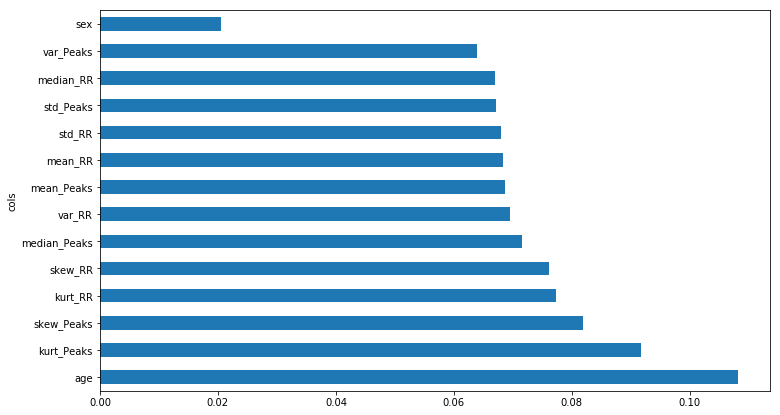

In [100]:
plot_fi(fi[:25]);